In [24]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
import json
from pathlib import Path
import datetime
from shapely import wkt
from tqdm import tqdm

from joblib import Parallel, delayed
import multiprocessing

import powerlaw



In [28]:
import trackintel as ti

from utils.utils import load_data

ti.__version__

'1.3.1'

In [29]:
import matplotlib.pyplot as plt
import matplotlib

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["xtick.labelsize"] = 13
matplotlib.rcParams["ytick.labelsize"] = 13
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

%matplotlib inline

# Basic statistics

In [5]:
sp = pd.read_csv(os.path.join("..", "data", "sp_all.csv"))
sp["started_at"] = pd.to_datetime(sp["started_at"], format='mixed', yearfirst=True, utc=True)
sp["finished_at"] = pd.to_datetime(sp["finished_at"], format='mixed', yearfirst=True, utc=True)

In [18]:
# sp.set_index("started_at").resample("T")
loc_visit_per_day = sp.groupby([sp['user_id'],pd.Grouper(freq='D', key="started_at")]).size()

In [24]:
loc_visit_per_day.mean(), loc_visit_per_day.median()

(4.183765816164449, 4.0)

In [27]:
7 * loc_visit_per_day.mean(), 7 * 2 * loc_visit_per_day.mean(), 7 * 3* loc_visit_per_day.mean(), 7 * 4 * loc_visit_per_day.mean()

(29.286360713151144, 58.57272142630229, 87.85908213945343, 117.14544285260457)

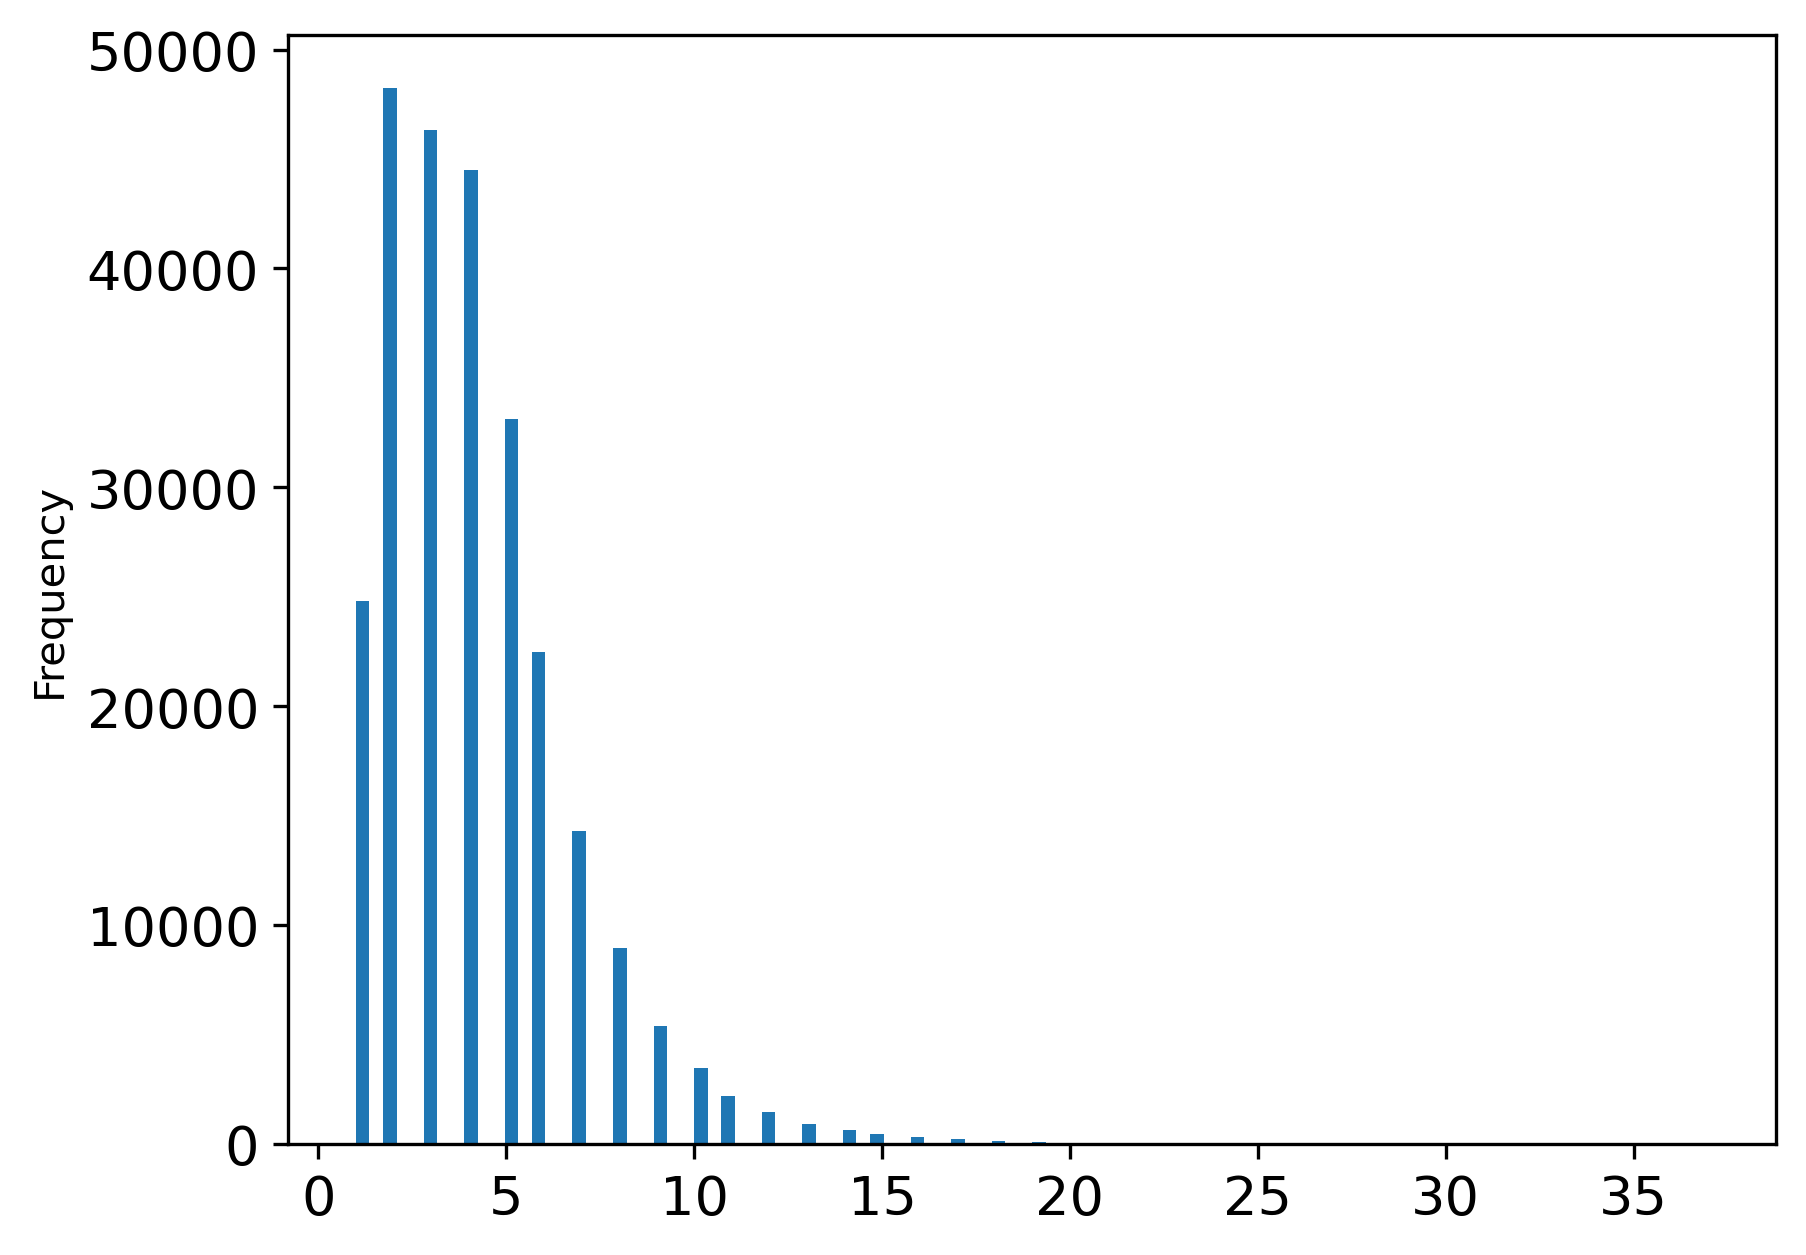

In [22]:
loc_visit_per_day.plot.hist(bins=100)

plt.show()

# Activity duration

In [30]:
level = 14
sp = pd.read_csv(os.path.join(f"../data/sp_all.csv"), index_col="id")
loc = pd.read_csv(os.path.join(f"../data/loc_s2_level10_{level}.csv"), index_col="id")

sp = load_data(sp, loc)
sp["length"] = sp["length"]/1000

sp["act_dur"]  = sp["act_duration"]
sp.loc[sp["act_dur"] > 60 * 24 * 2, "act_dur"] = 60 * 24 * 2

In [31]:
len(sp)

1079922

In [32]:
sp.head()

,id,user_id,started_at,finished_at,mode,length,geometry,duration,act_duration,location_id,level,start_day,start_min,weekday,act_dur
0,0,AAGAF,2019-10-09 11:30:34.141000,2019-10-10 05:43:17.674999,Car,0.000000,POINT (7.565219252705515 47.545616383391014),1092.0,1092.0,5157106436492230656,14,0,690,2,1092.0
1,1,AAGAF,2019-10-10 06:14:49.141999,2019-10-10 06:53:54.841000,Car,11.615409,POINT (7.563759803278834 47.54794768304769),39.0,70.0,5157106342002950144,14,1,374,3,70.0
2,2,AAGAF,2019-10-10 07:03:24.426000,2019-10-10 08:18:20.864000,Car,2.104856,POINT (7.581727914351441 47.5564374119498),74.0,84.0,5157107192406474752,14,1,423,3,84.0
3,3,AAGAF,2019-10-10 11:10:24.605999,2019-10-10 13:54:34.799339,Walk,4.847707,POINT (7.581729846308135 47.55641482529889),164.0,336.0,5157107192406474752,14,1,670,3,336.0
4,4,AAGAF,2019-10-11 06:15:49.739000,2019-10-11 11:36:29.907000,Bus,8.667529,POINT (7.565127647736598 47.54571219157556),320.0,1301.0,5157106436492230656,14,2,375,4,1301.0


In [33]:
sp["act_duration"].describe(), sp["act_dur"].describe()

(count    1.079922e+06
 mean     3.868940e+02
 std      7.413339e+02
 min      0.000000e+00
 25%      5.900000e+01
 50%      1.590000e+02
 75%      5.500000e+02
 max      1.208200e+05
 Name: act_duration, dtype: float64,
 count    1.079922e+06
 mean     3.670703e+02
 std      4.848072e+02
 min      0.000000e+00
 25%      5.900000e+01
 50%      1.590000e+02
 75%      5.500000e+02
 max      2.880000e+03
 Name: act_dur, dtype: float64)

In [34]:
# transform to hours
act_len = ((sp["act_duration"] + 1) / 60).values
act_len2 = ((sp["act_dur"] + 1) / 60).values

In [35]:
# fit power law
fit = powerlaw.Fit(act_len, xmin = 1/2880, xmin_distribution='power_law')
fit2 = powerlaw.Fit(act_len2, xmin = 1/2880, xmin_distribution='power_law')

In [36]:
def getAIC(fit, empr):
    aics = []

    aics.append(-2*np.sum(fit.truncated_power_law.loglikelihoods(empr))+4)
    aics.append(-2*np.sum(fit.power_law.loglikelihoods(empr))+2)
    aics.append(-2*np.sum(fit.lognormal.loglikelihoods(empr))+4)
    
    aics = aics-np.min(aics)
    
    down = np.sum([np.exp(-aic/2) for aic in aics])    
        
    res = {}
    res['truncated_power_law'] = np.exp(-aics[0]/2)/down
    res['power_law'] = np.exp(-aics[1]/2)/down
    res['lognormal'] = np.exp(-aics[2]/2)/down

    return res

print(getAIC(fit, act_len))
print(getAIC(fit2, act_len2))

{'truncated_power_law': 0.0, 'power_law': 0.0, 'lognormal': 1.0}
{'truncated_power_law': 0.0, 'power_law': 0.0, 'lognormal': 1.0}


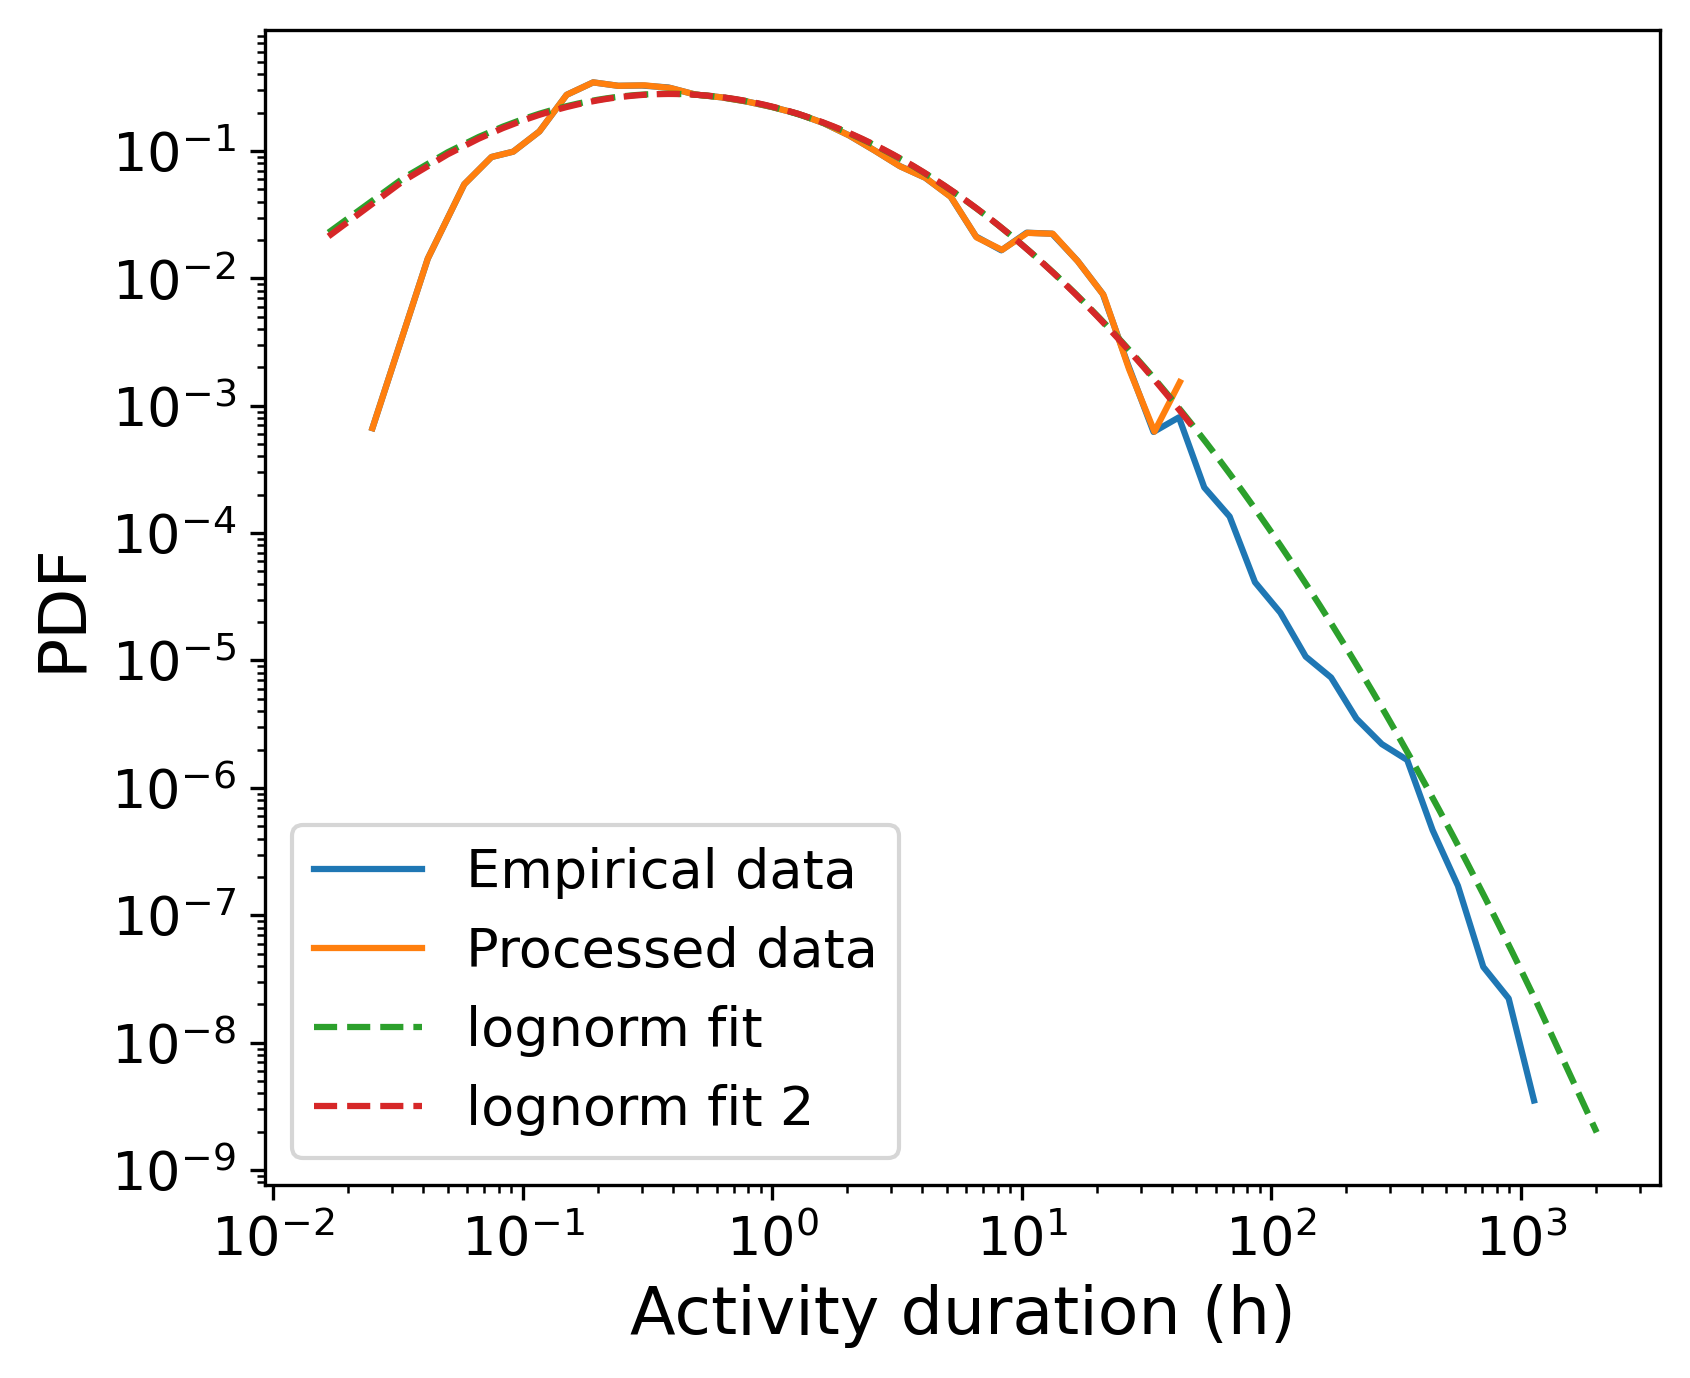

In [37]:
plt.figure(figsize=(6, 5))

# plotting
powerlaw.plot_pdf(act_len, label="Empirical data")
powerlaw.plot_pdf(act_len2, label="Processed data")
# fit.power_law.plot_pdf(linestyle="--", label="powerlaw fit")
# fit.truncated_power_law.plot_pdf(linestyle="--", color="k", alpha=0.6,label="Truncated power law fit")
fit.lognormal.plot_pdf(linestyle="--", label="lognorm fit")
fit2.lognormal.plot_pdf(linestyle="--", label="lognorm fit 2")

plt.legend(prop={"size": 13})
plt.xlabel("Activity duration (h)", fontsize=16)
plt.ylabel("PDF", fontsize=16)

# plt.savefig(r'..\data\fig\activity_duration.png', bbox_inches='tight', dpi=600)
plt.show()

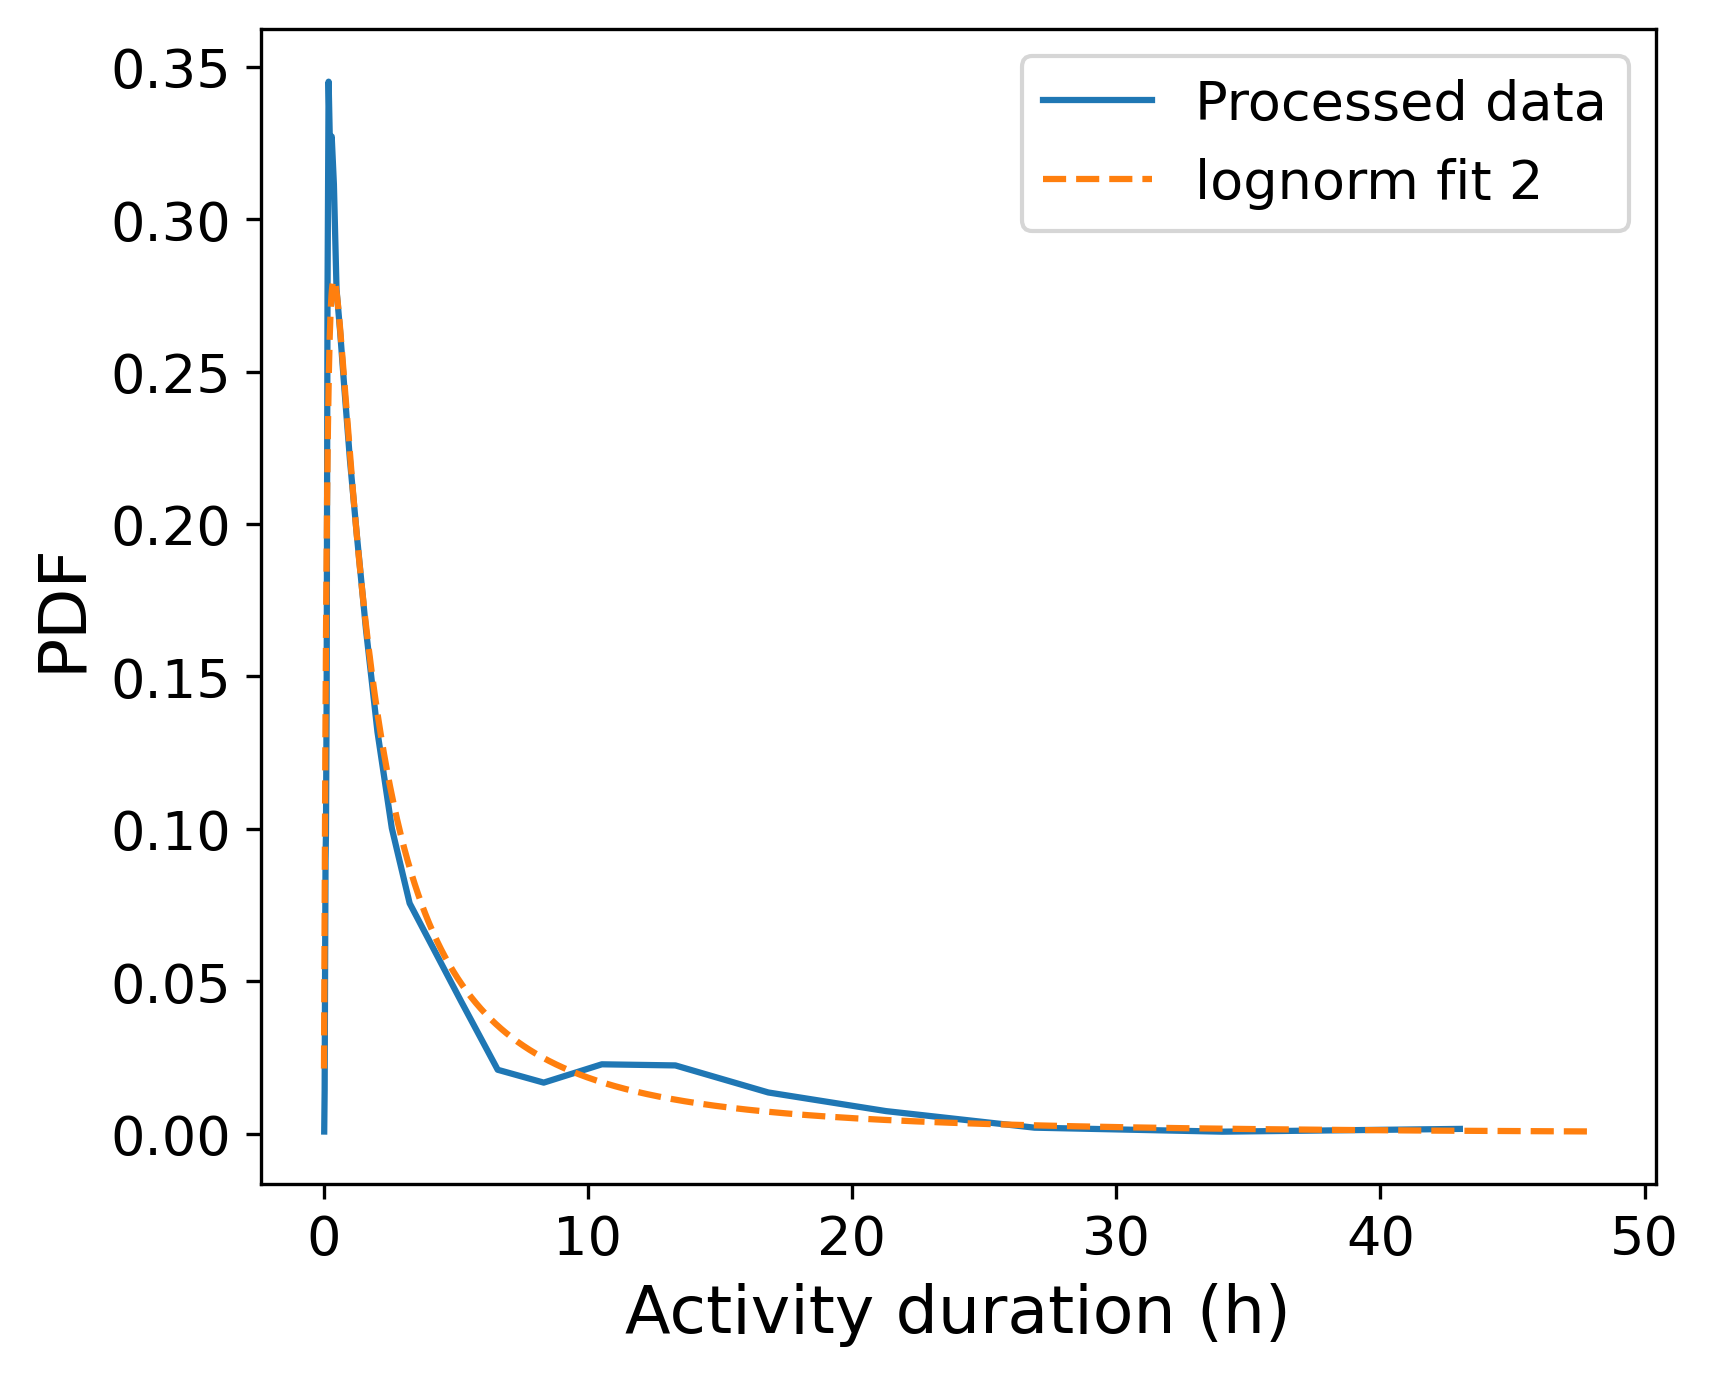

In [13]:
plt.figure(figsize=(6, 5))

# plotting
powerlaw.plot_pdf(act_len2, label="Processed data")
# fit.power_law.plot_pdf(linestyle="--", label="powerlaw fit")
# fit.truncated_power_law.plot_pdf(linestyle="--", color="k", alpha=0.6,label="Truncated power law fit")
fit2.lognormal.plot_pdf(linestyle="--", label="lognorm fit 2")

plt.legend(prop={"size": 13})
plt.xscale("linear")
plt.yscale("linear")
plt.xlabel("Activity duration (h)", fontsize=16)
plt.ylabel("PDF", fontsize=16)

# plt.savefig(r'..\data\fig\activity_duration.png', bbox_inches='tight', dpi=600)
plt.show()

# Activity start time

In [14]:
level = 14
sp = pd.read_csv(os.path.join(f"../data/sp_all.csv"), index_col="id")
loc = pd.read_csv(os.path.join(f"../data/loc_s2_level10_{level}.csv"), index_col="id")

sp = load_data(sp, loc)


In [15]:
sp["started_at"] = pd.to_datetime(sp["started_at"], format='mixed', yearfirst=True, utc=True)
sp["finished_at"] = pd.to_datetime(sp["finished_at"], format='mixed', yearfirst=True, utc=True)

In [16]:
sp["hour"] = sp["started_at"].dt.hour
proportion = (sp.groupby("hour").size()/sp.groupby("hour").size().sum() *100).values

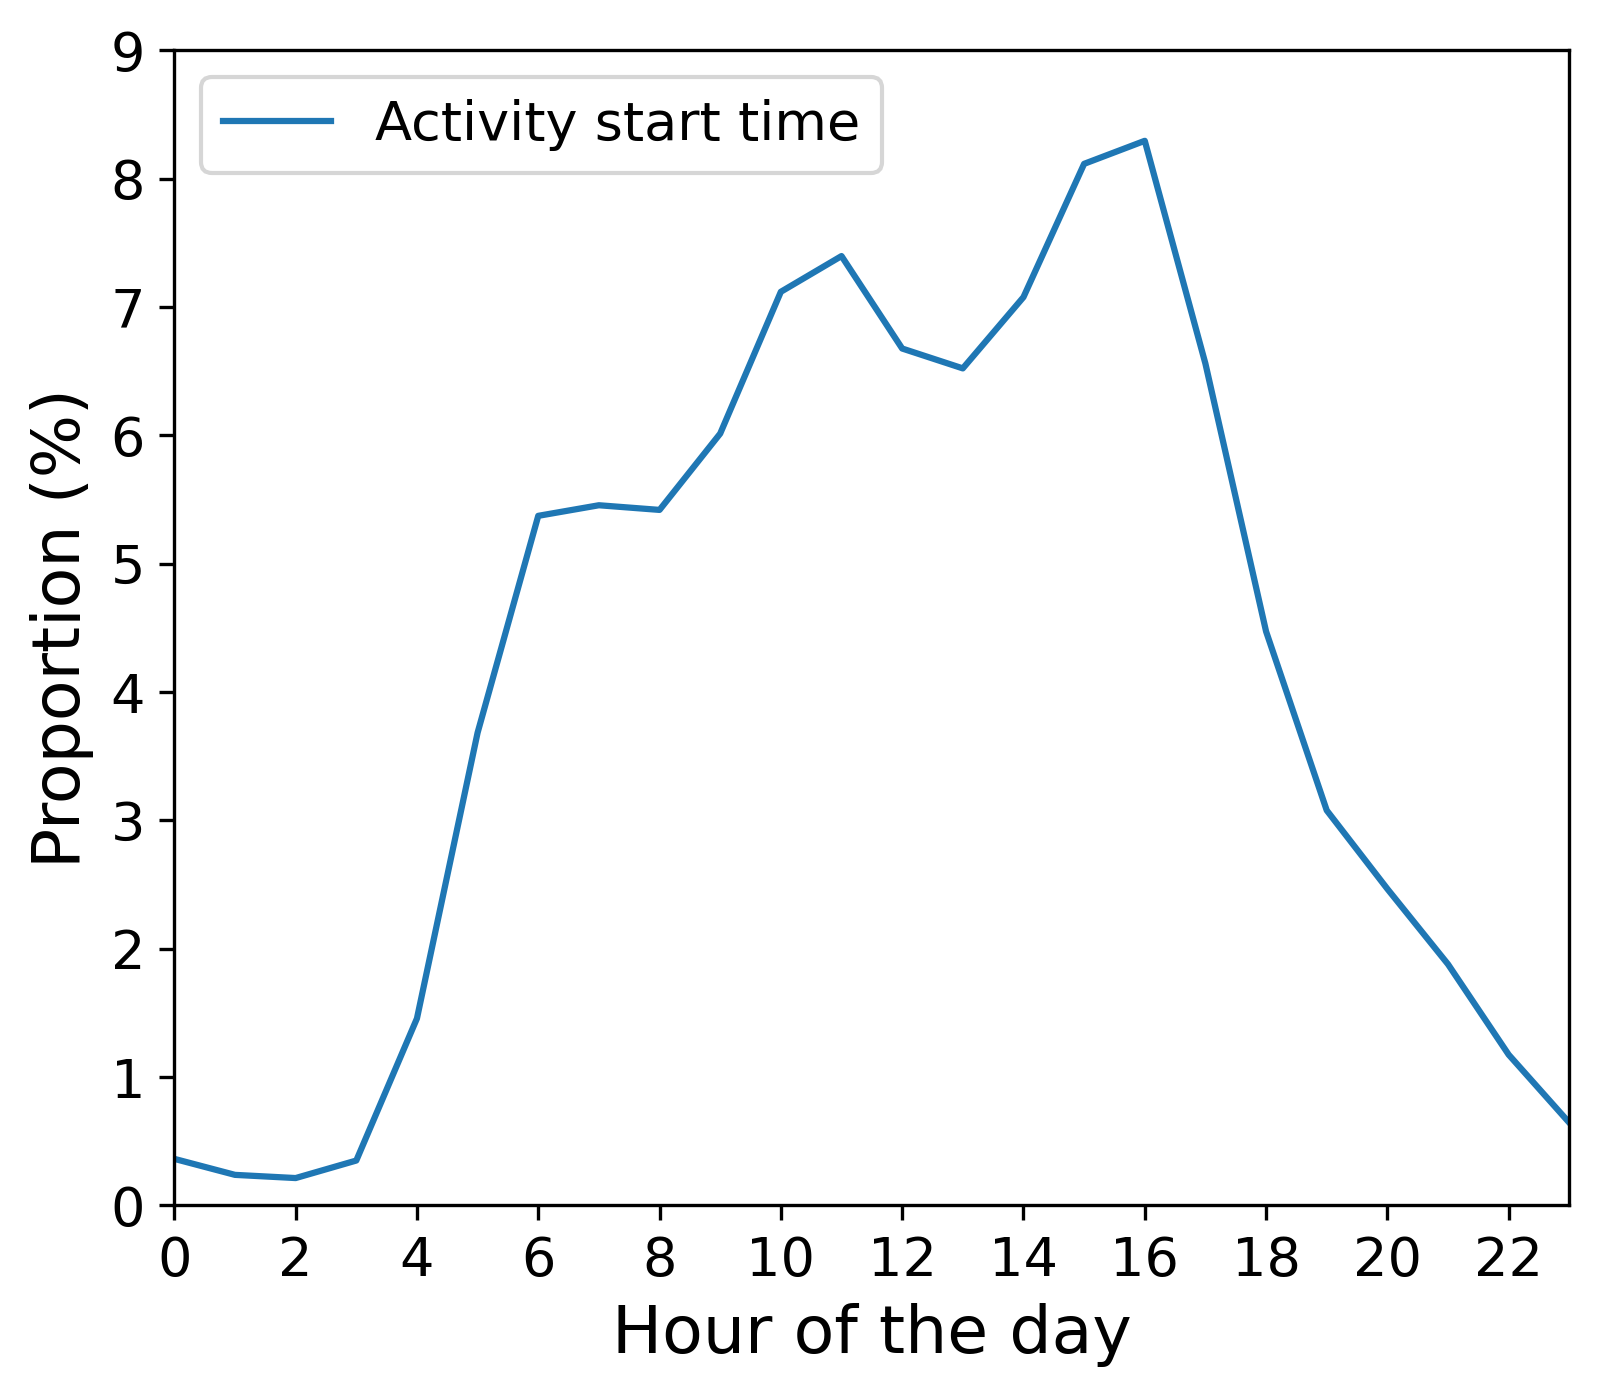

In [17]:
plt.figure(figsize=(6, 5))

plt.plot(np.arange(24), proportion, label="Activity start time")

plt.xticks(np.arange(0, 24, 2))
plt.xlim([0, 23])
plt.ylim([0, 9])
plt.xlabel("Hour of the day", fontsize = 16)
plt.ylabel("Proportion (%)", fontsize = 16)

# plt.rc('grid', linestyle="--", color='grey')
# plt.grid()

plt.legend(prop={"size": 13})
# plt.savefig(r'..\data\fig\activity_start.png', bbox_inches='tight', dpi=600)
plt.show()

# Jump length

In [ ]:
def getAIC(fit, empr):
    aics = []

    aics.append(-2*np.sum(fit.truncated_power_law.loglikelihoods(empr))+4)
    aics.append(-2*np.sum(fit.power_law.loglikelihoods(empr))+2)
    aics.append(-2*np.sum(fit.lognormal.loglikelihoods(empr))+4)
    
    aics = aics-np.min(aics)
    
    down = np.sum([np.exp(-aic/2) for aic in aics])    
        
    res = {}
    res['truncated_power_law'] = np.exp(-aics[0]/2)/down
    res['power_law'] = np.exp(-aics[1]/2)/down
    res['lognormal'] = np.exp(-aics[2]/2)/down

    return res

In [60]:
sp = pd.read_csv(os.path.join("..", "data", "sp_all.csv"))
sp["started_at"] = pd.to_datetime(sp["started_at"], format='mixed', yearfirst=True, utc=True)
sp["finished_at"] = pd.to_datetime(sp["finished_at"], format='mixed', yearfirst=True, utc=True)

loc = pd.read_csv(os.path.join("..", "data", "loc.csv"))[["id", "center"]]

# get the location geometry
sp = sp.merge(loc.rename(columns={"id":"location_id", "center":"loc_geometry"}), how="left", on="location_id")


# load all geometry
sp["geometry"] = gpd.GeoSeries.from_wkt(sp["geometry"])
sp["loc_geometry"] = gpd.GeoSeries.from_wkt(sp["loc_geometry"])

In [56]:
sp

,id,user_id,started_at,finished_at,location_id,geometry,duration,act_duration,loc_geometry
0,295826,AAGAF,2019-10-09 11:30:34.141000+00:00,2019-10-10 05:43:17.674999+00:00,0,POINT (7.565219252705515 47.545616383391014),1092.0,1092.0,POINT (7.5651185206124083 47.5456714741762241)
1,303827,AAGAF,2019-10-10 06:14:49.141999+00:00,2019-10-10 06:53:54.841000+00:00,1,POINT (7.563759803278834 47.54794768304769),39.0,70.0,POINT (7.5637598032788320 47.5479476830476884)
2,304385,AAGAF,2019-10-10 07:03:24.426000+00:00,2019-10-10 08:18:20.864000+00:00,2,POINT (7.581727914351441 47.5564374119498),74.0,84.0,POINT (7.5817288803297895 47.5564261186243442)
3,307381,AAGAF,2019-10-10 11:10:24.605999+00:00,2019-10-10 13:54:34.799339+00:00,2,POINT (7.581729846308135 47.55641482529889),164.0,336.0,POINT (7.5817288803297895 47.5564261186243442)
4,316446,AAGAF,2019-10-11 06:15:49.739000+00:00,2019-10-11 11:36:29.907000+00:00,0,POINT (7.565127647736598 47.54571219157556),320.0,1301.0,POINT (7.5651185206124083 47.5456714741762241)
...,...,...,...,...,...,...,...,...,...
1079917,576535,ZZYIC,2019-10-31 15:26:16.467000+00:00,2019-10-31 17:07:26.619999+00:00,11963,POINT (8.779955508622193 47.37271491009289),101.0,182.0,POINT (8.7799842793859586 47.3727068800868523)
1079918,578695,ZZYIC,2019-10-31 17:10:49.924000+00:00,2019-10-31 19:02:57.200000+00:00,162302,POINT (8.778435090438501 47.37405248736652),112.0,115.0,POINT (8.7784350904385011 47.3740524873665194)
1079919,580864,ZZYIC,2019-10-31 19:22:37.476999+00:00,2019-11-01 07:45:05.378999+00:00,162235,POINT (8.777547641952243 47.375817643427915),742.0,762.0,POINT (8.7774544443796518 47.3758169375706828)
1079920,584556,ZZYIC,2019-11-01 07:51:34.239000+00:00,2019-11-01 09:09:36.236000+00:00,162235,POINT (8.77725754861859 47.375938470094724),78.0,84.0,POINT (8.7774544443796518 47.3758169375706828)


{'truncated_power_law': 0.0, 'power_law': 0.0, 'lognormal': 1.0}
{'truncated_power_law': 0.0, 'power_law': 0.0, 'lognormal': 1.0}


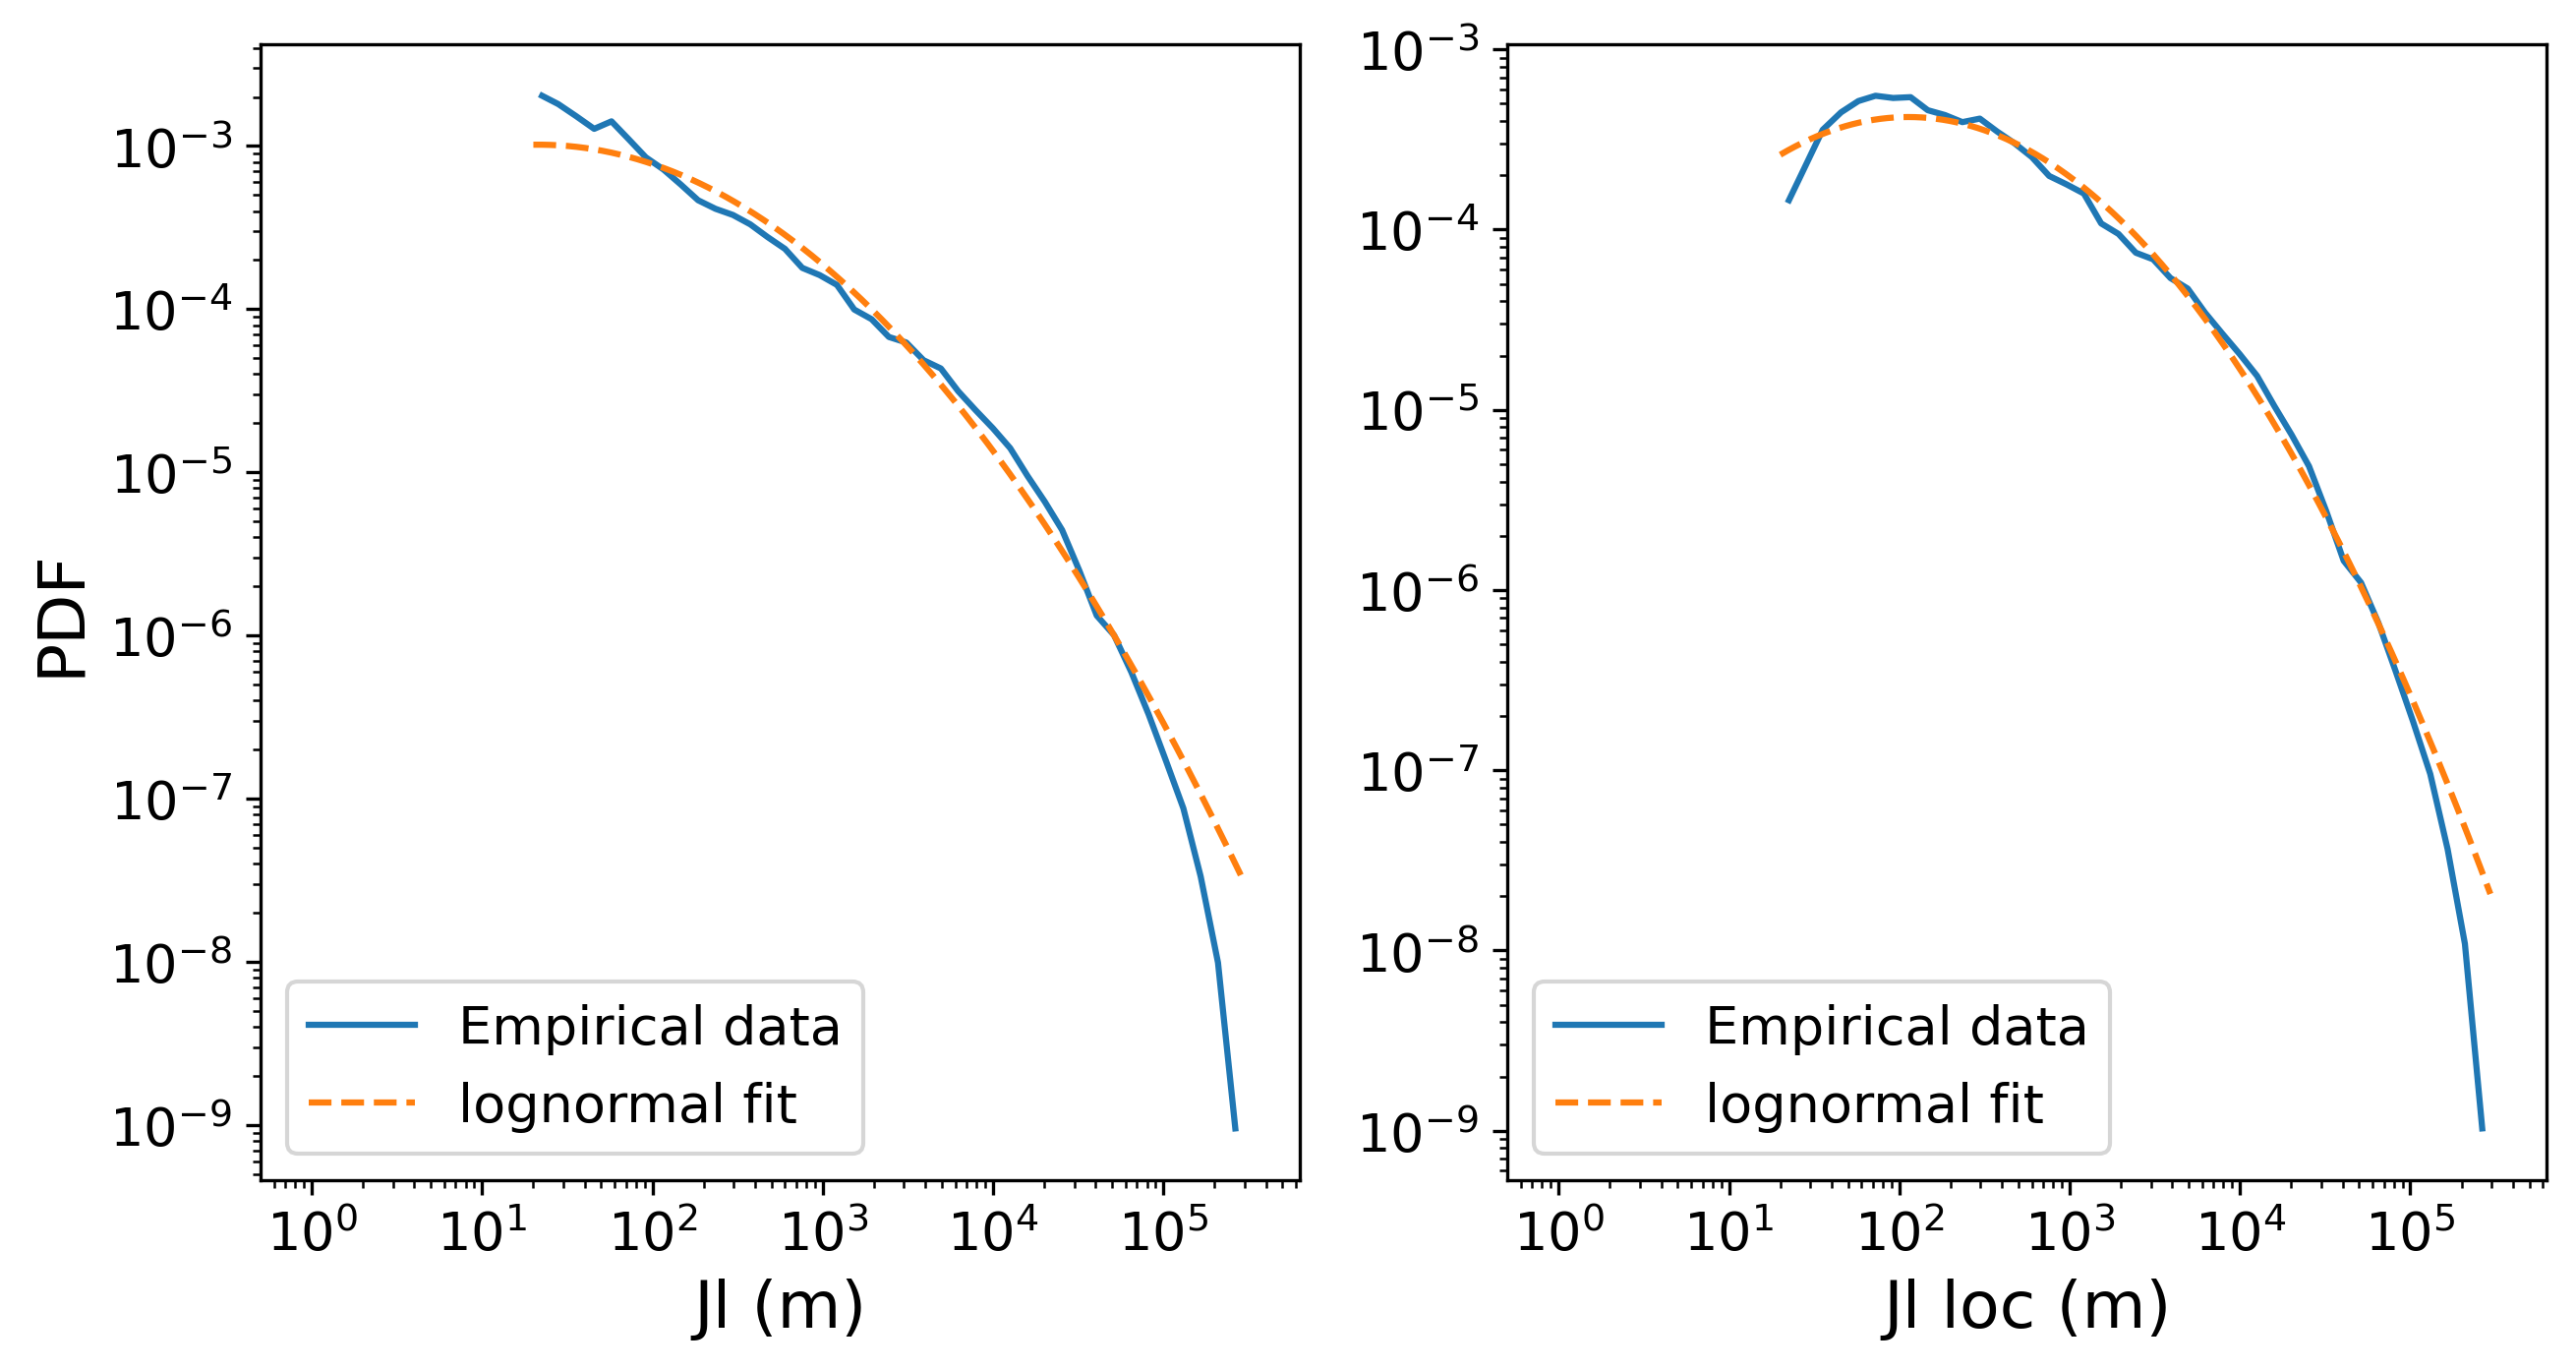

In [64]:
def plot_best_fit(axis, sp, geom_col = "geometry"):
    # geometry or loc_geometry
    if geom_col == "loc_geometry":
        sp = sp.drop(columns="geometry").rename(columns={"loc_geometry":"geometry"})
    
    sp_ti = gpd.GeoDataFrame(sp, crs="EPSG:4326", geometry="geometry")
    sp_ti = ti.io.read_staypoints_gpd(sp_ti)

    jp = ti.analysis.jump_length(sp_ti)
    jp = jp[jp>20]
    
    # fit power law
    # we use xim 20 to account for GPS noise 
    fit = powerlaw.Fit(jp, xmin = 20, xmin_distribution='power_law')

    print(getAIC(fit, jp))

    # plotting
    powerlaw.plot_pdf(jp, label="Empirical data", ax=axis)
    # fit.power_law.plot_pdf(linestyle="--", label="powerlaw fit")
    # fit.truncated_power_law.plot_pdf(linestyle="--", color="k", alpha=0.6,label="Truncated power law fit")
    fit.lognormal.plot_pdf(linestyle="--", label="lognormal fit", ax=axis)
    
    axis.legend(prop={"size": 13})
    axis.set_xlim([10**-.3, 10**5.8])


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plot_best_fit(axs[0], sp.copy(), geom_col = "geometry")
plot_best_fit(axs[1], sp.copy(), geom_col = "loc_geometry")

axs[0].set_xlabel("Jl (m)", fontsize=16)
axs[1].set_xlabel("Jl loc (m)", fontsize=16)
axs[0].set_ylabel("PDF", fontsize=16)

plt.show()

## After s2 projection

In [112]:
sp = pd.read_csv(os.path.join("..", "data", "sp_all.csv"), index_col="id")
sp["started_at"] = pd.to_datetime(sp["started_at"], format='mixed', yearfirst=True, utc=True)
sp["finished_at"] = pd.to_datetime(sp["finished_at"], format='mixed', yearfirst=True, utc=True)

# read locations
# 14
loc = pd.read_csv(os.path.join("..", "data", "loc_s2_level10_14.csv"))[["id", "s2_id"]]
s2_loc = pd.read_csv(os.path.join("..", "data", "s2_loc_all_level10_14.csv"))
loc = loc.merge(s2_loc.rename(columns={"loc_id":"s2_id"})[["s2_id", "geometry"]], on ="s2_id")

sp = sp.merge(loc.rename(columns={"id":"location_id", "geometry":"loc_14_geometry"})[["location_id", "loc_14_geometry"]], how="left", on="location_id")

# 13
loc = pd.read_csv(os.path.join("..", "data", "loc_s2_level10_13.csv"))[["id", "s2_id"]]
s2_loc = pd.read_csv(os.path.join("..", "data", "s2_loc_all_level10_13.csv"))
loc = loc.merge(s2_loc.rename(columns={"loc_id":"s2_id"})[["s2_id", "geometry"]], on ="s2_id")

sp = sp.merge(loc.rename(columns={"id":"location_id", "geometry":"loc_13_geometry"})[["location_id", "loc_13_geometry"]], how="left", on="location_id")

# load all geometry
sp["geometry"] = gpd.GeoSeries.from_wkt(sp["geometry"])
sp["loc_14_geometry"] = gpd.GeoSeries.from_wkt(sp["loc_14_geometry"])
sp["loc_13_geometry"] = gpd.GeoSeries.from_wkt(sp["loc_13_geometry"])

In [113]:
sp

,user_id,started_at,finished_at,location_id,geometry,duration,act_duration,loc_14_geometry,loc_13_geometry
0,AAGAF,2019-10-09 11:30:34.141000+00:00,2019-10-10 05:43:17.674999+00:00,0,POINT (7.56522 47.54562),1092.0,1092.0,POINT (7.56759 47.54630),POINT (7.57118 47.54854)
1,AAGAF,2019-10-10 06:14:49.141999+00:00,2019-10-10 06:53:54.841000+00:00,1,POINT (7.56376 47.54795),39.0,70.0,POINT (7.56169 47.54669),POINT (7.55939 47.54932)
2,AAGAF,2019-10-10 07:03:24.426000+00:00,2019-10-10 08:18:20.864000+00:00,2,POINT (7.58173 47.55644),74.0,84.0,POINT (7.58197 47.55523),POINT (7.58557 47.55746)
3,AAGAF,2019-10-10 11:10:24.605999+00:00,2019-10-10 13:54:34.799339+00:00,2,POINT (7.58173 47.55641),164.0,336.0,POINT (7.58197 47.55523),POINT (7.58557 47.55746)
4,AAGAF,2019-10-11 06:15:49.739000+00:00,2019-10-11 11:36:29.907000+00:00,0,POINT (7.56513 47.54571),320.0,1301.0,POINT (7.56759 47.54630),POINT (7.57118 47.54854)
...,...,...,...,...,...,...,...,...,...
1079917,ZZYIC,2019-10-31 15:26:16.467000+00:00,2019-10-31 17:07:26.619999+00:00,11963,POINT (8.77996 47.37271),101.0,182.0,POINT (8.77644 47.37098),POINT (8.78017 47.37316)
1079918,ZZYIC,2019-10-31 17:10:49.924000+00:00,2019-10-31 19:02:57.200000+00:00,162302,POINT (8.77844 47.37405),112.0,115.0,POINT (8.77793 47.37580),POINT (8.78017 47.37316)
1079919,ZZYIC,2019-10-31 19:22:37.476999+00:00,2019-11-01 07:45:05.378999+00:00,162235,POINT (8.77755 47.37582),742.0,762.0,POINT (8.77793 47.37580),POINT (8.78017 47.37316)
1079920,ZZYIC,2019-11-01 07:51:34.239000+00:00,2019-11-01 09:09:36.236000+00:00,162235,POINT (8.77726 47.37594),78.0,84.0,POINT (8.77793 47.37580),POINT (8.78017 47.37316)


{'truncated_power_law': 0.0, 'power_law': 0.0, 'lognormal': 1.0}
{'truncated_power_law': 0.0, 'power_law': 0.0, 'lognormal': 1.0}
{'truncated_power_law': 0.0, 'power_law': 0.0, 'lognormal': 1.0}


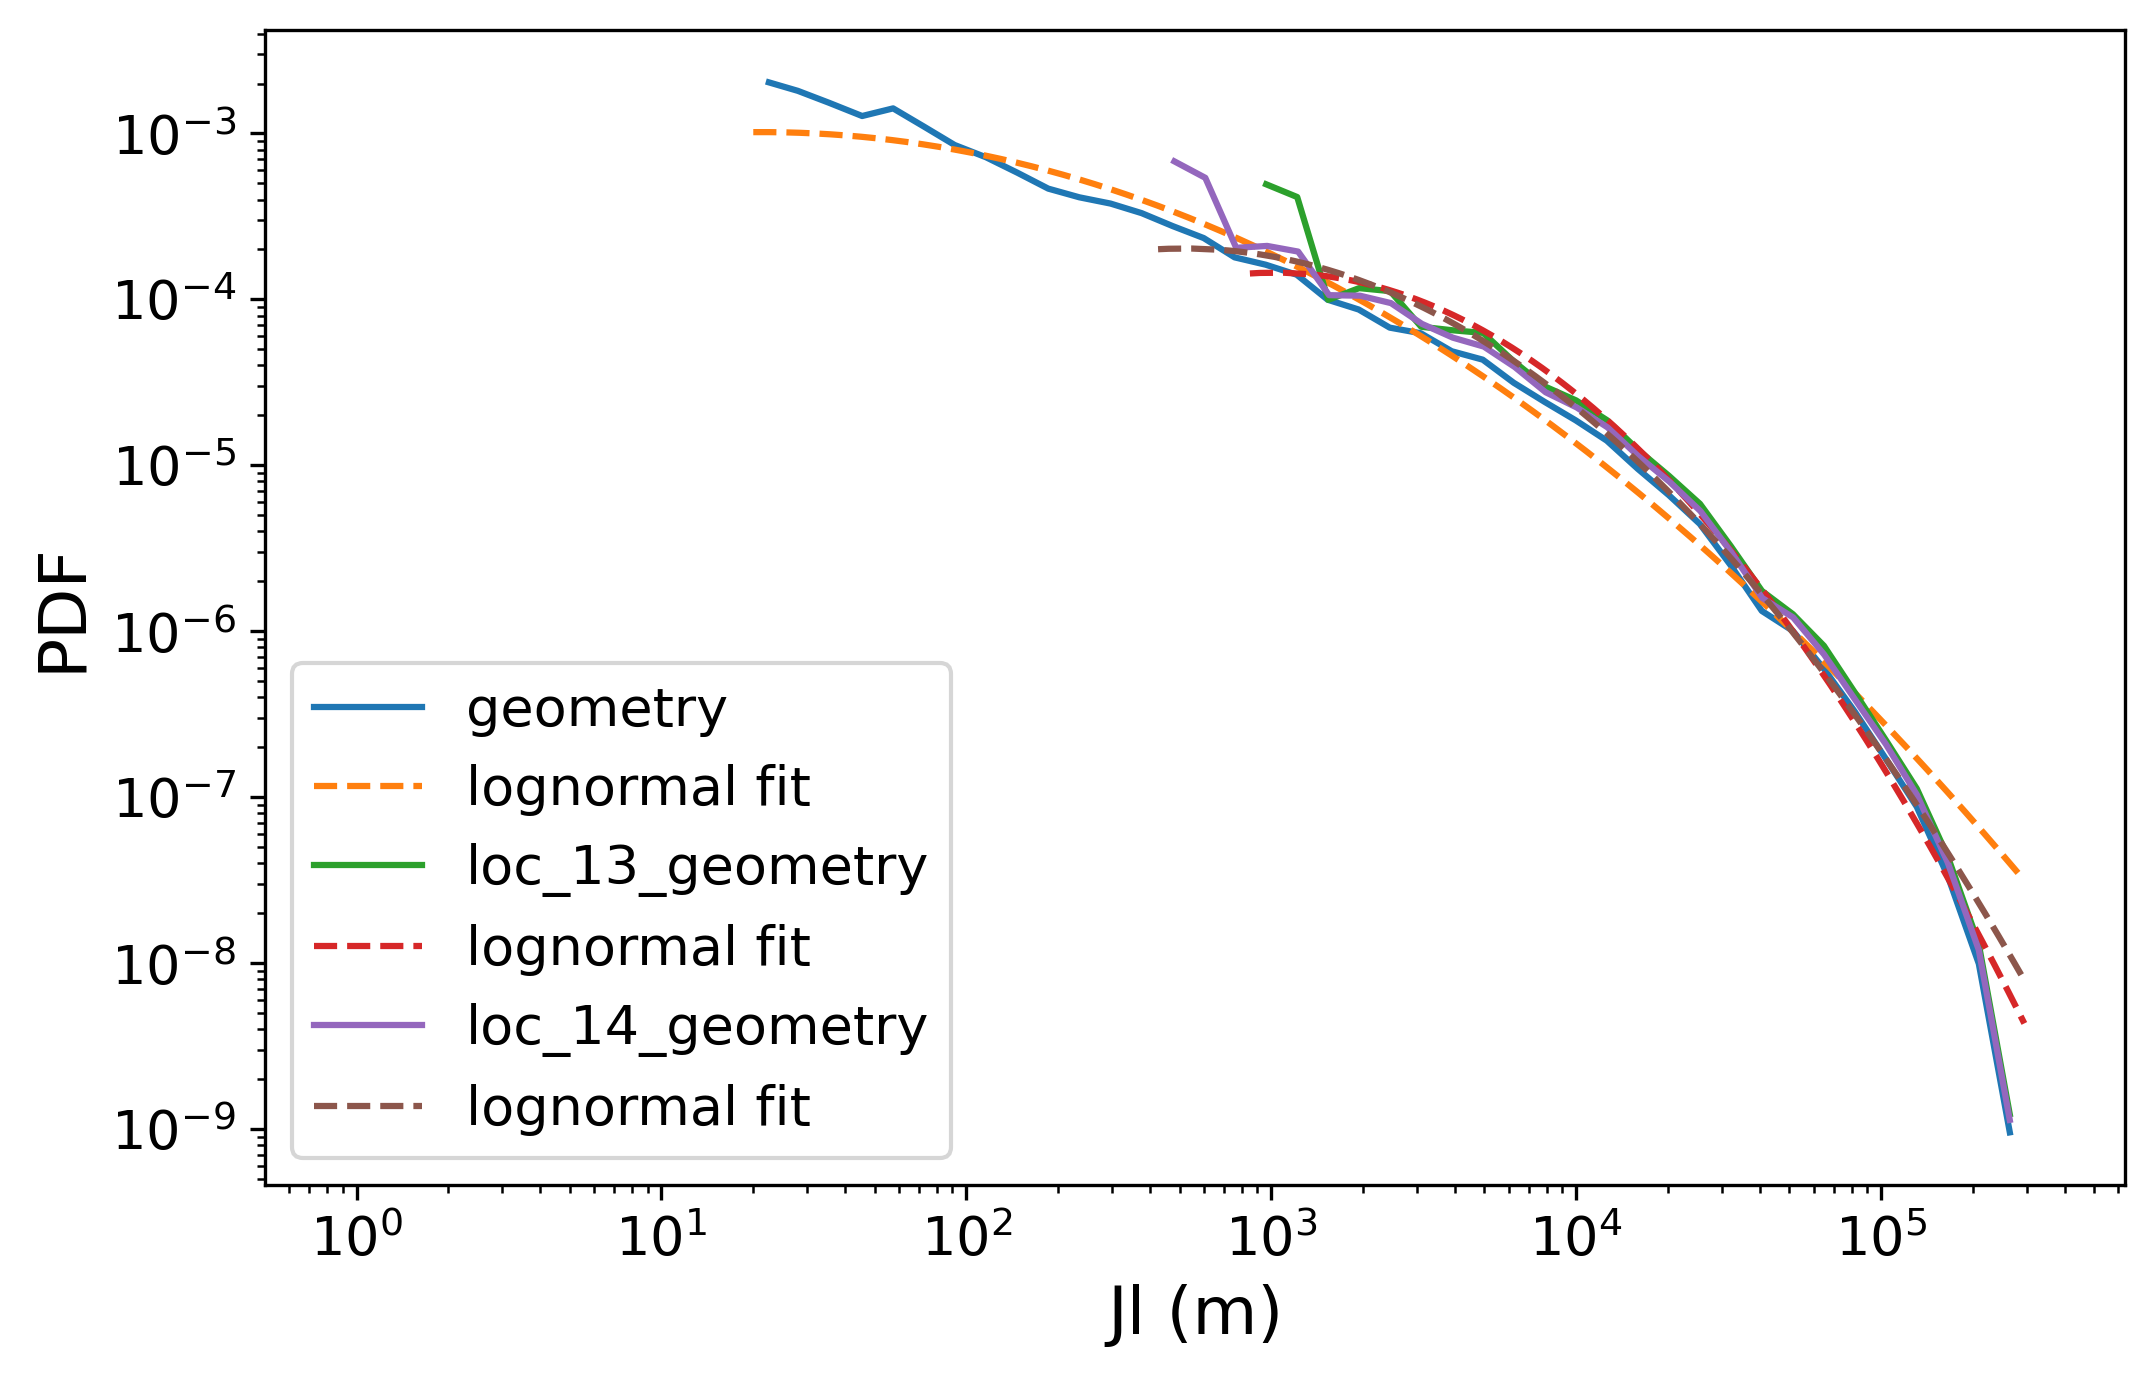

In [119]:
def plot_best_fit(axis, sp, geom_col = "geometry"):
    # geometry or loc_geometry
    if geom_col != "geometry":
        sp = sp.drop(columns="geometry").rename(columns={geom_col:"geometry"})
    
    sp_ti = gpd.GeoDataFrame(sp, crs="EPSG:4326", geometry="geometry")
    sp_ti = ti.io.read_staypoints_gpd(sp_ti)

    jp = ti.analysis.jump_length(sp_ti)
    jp = jp[jp>20]
    
    # fit power law
    # we use xim 20 to account for GPS noise 
    fit = powerlaw.Fit(jp, xmin = 20, xmin_distribution='power_law')

    print(getAIC(fit, jp))

    # plotting
    powerlaw.plot_pdf(jp, label=geom_col, ax=axis)
    # fit.power_law.plot_pdf(linestyle="--", label="powerlaw fit")
    # fit.truncated_power_law.plot_pdf(linestyle="--", color="k", alpha=0.6,label="Truncated power law fit")
    fit.lognormal.plot_pdf(linestyle="--", label="lognormal fit", ax=axis)
    
    axis.legend(prop={"size": 13})
    axis.set_xlim([10**-.3, 10**5.8])

    return fit


fig, axs = plt.subplots(1, 1, figsize=(8, 5))

plot_best_fit(axs, sp.copy(), geom_col = "geometry")
plot_best_fit(axs, sp.copy(), geom_col = "loc_13_geometry")
plot_best_fit(axs, sp.copy(), geom_col = "loc_14_geometry")

axs.set_xlabel("Jl (m)", fontsize=16)
# axs[1].set_xlabel("Jl level 13 (m)", fontsize=16)
# axs[2].set_xlabel("Jl level 14 (m)", fontsize=16)

axs.set_ylabel("PDF", fontsize=16)

plt.show()

# Entropy

# Radius of Gyration

# Modal split

In [28]:
quality_path = os.path.join("..", "data", "quality")
quality_file = os.path.join(quality_path, "mobis_filtered.csv")

valid_users = pd.read_csv(quality_file)["user_id"].values

In [29]:
valid_users

array(['AAGAF', 'AAINS', 'AAQME', ..., 'ZZKKH', 'ZZVAK', 'ZZYIC'],
      dtype=object)

In [30]:
# read file storage
Dataset_file = os.path.join("..", "paths.json")
with open(Dataset_file) as json_file:
    CONFIG = json.load(json_file)

In [31]:
tpls = pd.read_csv(os.path.join(CONFIG["raw_mobis"], "legs.csv"), usecols=[0, 1, 4, 6])

In [32]:
tpls_filter = tpls.loc[tpls["user_id"].isin(valid_users)].copy()

In [33]:
tpls_filter["started_at"] = pd.to_datetime(tpls_filter["started_at"], format='mixed', yearfirst=True, utc=True)
tpls_filter["finished_at"] = pd.to_datetime(tpls_filter["finished_at"], format='mixed', yearfirst=True, utc=True)

In [34]:
tpls_filter["mode_clean"] = tpls_filter["mode"].apply(lambda x:x[6:])

In [35]:
tpls_filter["mode_clean"].value_counts()

mode_clean
Walk                  1072436
Car                    690685
Bus                     97156
Bicycle                 79175
LightRail               55935
Train                   38643
Tram                    38264
RegionalTrain           24550
Ebicycle                 8828
Subway                   7690
MotorbikeScooter         5082
Motorbike                4552
Ski                      3225
Airplane                 3029
Boat                     2134
Cablecar                 2133
TaxiUber                 1293
CarsharingMobility        974
Scooter                   761
Etrottinett               548
RidepoolingPikmi          250
Bikesharing                88
Escooter                   46
Ferry                       8
Aerialway                   3
Name: count, dtype: int64

In [36]:
mode2category = {
    "Walk":"Walk",
    "Car":"Car",
    "Bus":"Bus",
    "Bicycle":"Bicycle",
    "LightRail":"Train",
    "Train":"Train",
    "Tram":"Tram",
    "RegionalTrain":"Train",
    "Ebicycle":"Bicycle",
    "Subway":"Tram",
    "MotorbikeScooter":"Bicycle",
    "Motorbike":"Bicycle",
    "Ski":"Other",
    "Airplane":"Other",
    "Boat":"Boat",
    "Cablecar":"Other",
    "TaxiUber":"Car",
    "CarsharingMobility":"Car",
    "Scooter":"Bicycle",
    "Etrottinett":"Bicycle",
    "RidepoolingPikmi":"Car",
    "Bikesharing":"Bicycle",
    "Escooter":"Bicycle",
    "Ferry":"Boat",
    "Aerialway":"Other",
}
tpls_filter["mode_clean"] = tpls_filter["mode_clean"].map(mode2category)

In [37]:
tpls_filter = tpls_filter.loc[tpls_filter["mode_clean"]!="Other"]

In [38]:
tpls_filter.head()

,started_at,finished_at,mode,user_id,mode_clean
0,2019-11-04 15:01:30.609999+00:00,2019-11-04 15:03:08.598999+00:00,Mode::Walk,CDPXB,Walk
1,2019-11-04 15:24:39.563999+00:00,2019-11-04 15:26:23.260999+00:00,Mode::Walk,CDPXB,Walk
2,2019-11-05 17:11:59.737999+00:00,2019-11-05 17:13:12.887000+00:00,Mode::Walk,CDPXB,Walk
3,2019-11-05 20:16:31.404999+00:00,2019-11-05 20:20:07.430999+00:00,Mode::Bus,CDPXB,Bus
4,2019-11-05 20:20:07.430999+00:00,2019-11-05 20:22:14.246000+00:00,Mode::Walk,CDPXB,Walk


In [40]:
tpls = tpls_filter.copy()  # copy as we add additional columns on tpls

# count on mode, sum on length and duration
agg = "sum"
metric = "duration"  # count on mode
freq = "ME"
tpls["duration"] = (tpls["finished_at"] - tpls["started_at"]).dt.total_seconds()

group = []
tpls.set_index("started_at", inplace=True)
tpls.index.name = "timestamp"
group.append(pd.Grouper(freq=freq))

modal_split = pd.pivot_table(tpls, index=group, columns=["mode_clean"], aggfunc={metric: agg}, fill_value=0)
if group:  # non-empty group creates MultiIndex that we need to handle
    modal_split.columns = modal_split.columns.droplevel(0)

modal_split = modal_split.div(modal_split.sum(axis=1), axis=0) * 100

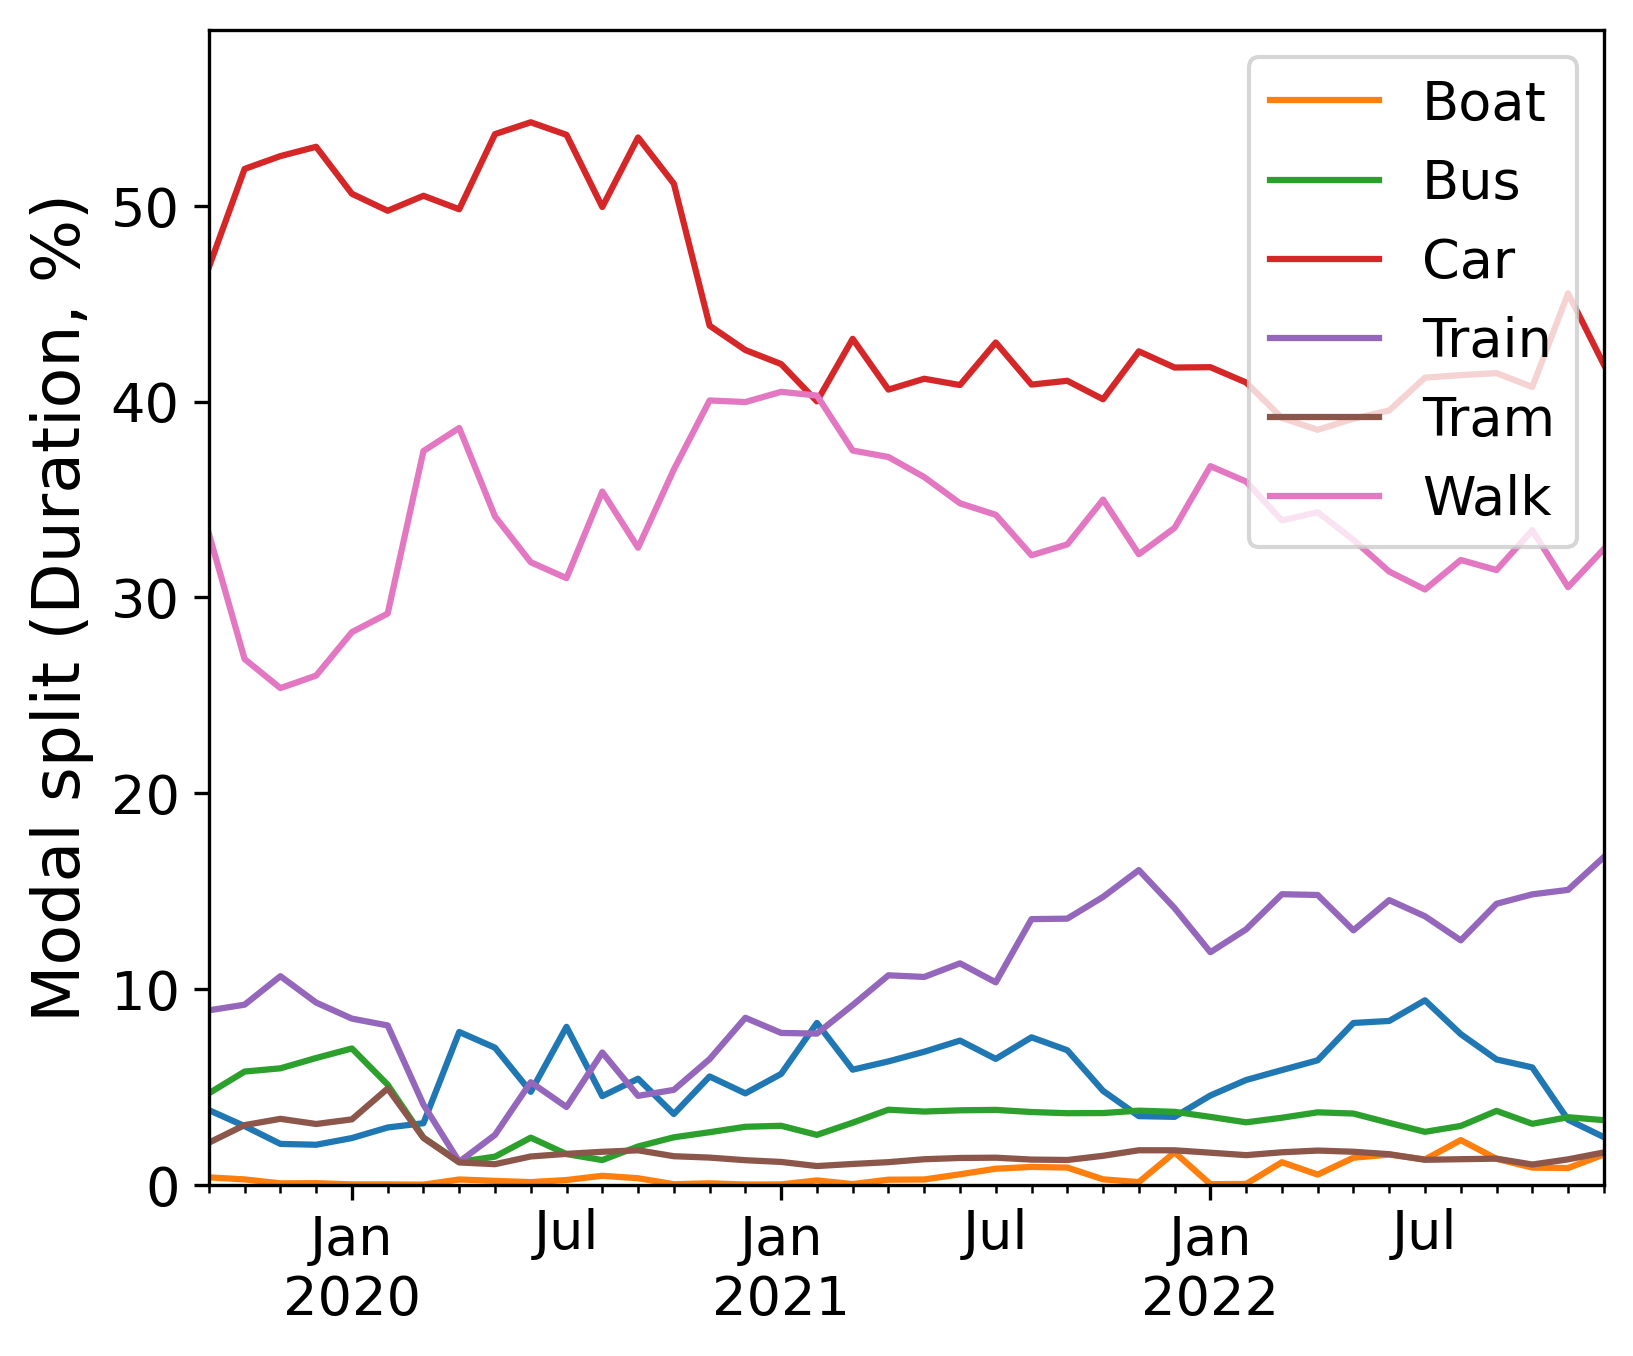

In [41]:
fig, ax = plt.subplots(figsize=(6,5))

modal_split.plot(ax=ax)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], prop={"size": 13}, loc=1)

ax.set_ylim([0, 59])

ax.set_xlabel("")
ax.set_ylabel("Modal split (Duration, %)", fontsize = 16)

# plt.savefig(r'..\data\fig\modal_split.png', bbox_inches='tight', dpi=600)
plt.show()

In [42]:
level = 14
sp = pd.read_csv(os.path.join(f"../data/sp_all.csv"), index_col="id")
loc = pd.read_csv(os.path.join(f"../data/loc_s2_level10_{level}.csv"), index_col="id")

sp = load_data(sp, loc)

In [45]:
sp["mode"].value_counts() / sp["mode"].value_counts().sum() * 100

mode
Car        49.628029
Walk       31.432455
Train       7.226077
Bicycle     5.679484
Bus         4.054367
Tram        1.720032
Other       0.259556
Name: count, dtype: float64

# POIs

In [ ]:
# get all the pofws, 1
pofw_file = gpd.read_file(os.path.join("data", "poi", "ori", "gis_osm_pofw_free_1.shp"))

# get all the transport, 4
transport_file = gpd.read_file(os.path.join("data", "poi", "ori", "gis_osm_transport_free_1.shp"))

# drop the trees and get the beaches, 1
natural_file = gpd.read_file(os.path.join("data", "poi", "ori", "gis_osm_natural_free_1.shp"))
natural_file = natural_file.loc[natural_file["fclass"] != "tree"]

natural_a_file = gpd.read_file(os.path.join("data", "poi", "ori", "gis_osm_natural_a_free_1.shp"))
natural_a_file = natural_a_file.loc[natural_a_file["fclass"].isin(["beach"])].reset_index(drop=True)
natural_a_file["geometry"] = natural_a_file.to_crs("EPSG:2056").geometry.centroid.to_crs("EPSG:4326")

# get all the pois, 11
poi_file = gpd.read_file(os.path.join("data", "poi", "ori", "gis_osm_pois_free_1.shp"))

# get the parking slots of traffic point file, 4
traffic_file = gpd.read_file(os.path.join("data", "poi", "ori", "gis_osm_traffic_free_1.shp"))
traffic_file = (
    traffic_file.loc[
        traffic_file["fclass"].isin(
            [
                "parking",
                "parking_bicycle",
                "parking_underground",
                "parking_multistorey",
            ]
        )
    ]
    .reset_index(drop=True)
    .copy()
)

# get the parking slots of traffic area file
traffic_a_file = gpd.read_file(os.path.join("data", "poi", "ori", "gis_osm_traffic_a_free_1.shp"))
traffic_a_file = (
    traffic_a_file.loc[
        traffic_a_file["fclass"].isin(
            [
                "parking",
                "parking_bicycle",
                "parking_underground",
                "parking_multistorey",
            ]
        )
    ]
    .reset_index(drop=True)
    .copy()
)
traffic_a_file["geometry"] = traffic_a_file.to_crs("EPSG:2056").geometry.centroid.to_crs("EPSG:4326")


In [18]:
import geopandas as gpd

# get all the pois, 11
poi_file = gpd.read_file(os.path.join("..", "data", "poi", "ori", "gis_osm_pois_free_1.shp"))

In [19]:
poi_file["fclass"].value_counts()[:20]

fclass
bench                  77528
tourist_info           48548
waste_basket           19708
restaurant             14407
drinking_water         12906
vending_any            12400
post_box                7619
pitch                   6752
fountain                5654
toilet                  4964
picnic_site             4833
hairdresser             4320
playground              4014
viewpoint               3838
camera_surveillance     3640
supermarket             3418
clothes                 3387
cafe                    3190
recycling_glass         2673
convenience             2630
Name: count, dtype: int64

In [11]:
poi_file.loc[poi_file["fclass"]=="supermarket"].to_file(os.path.join("..", "data", "poi", "visualize", "supermarket.shp"))

In [20]:
poi_file.loc[poi_file["fclass"]=="hairdresser"].to_file(os.path.join("..", "data", "poi", "visualize", "hairdresser.shp"))

In [12]:
poi_file.loc[poi_file["fclass"]=="restaurant"].to_file(os.path.join("..", "data", "poi", "visualize", "restaurant.shp"))

In [18]:
traffic_a_file = gpd.read_file(os.path.join("..", "data", "poi", "ori", "gis_osm_traffic_a_free_1.shp"))
traffic_a_file = (
    traffic_a_file.loc[
        traffic_a_file["fclass"].isin(
            [
                "parking",
                "parking_bicycle",
                "parking_underground",
                "parking_multistorey",
            ]
        )
    ]
    .reset_index(drop=True)
    .copy()
)
traffic_a_file["geometry"] = traffic_a_file.to_crs("EPSG:2056").geometry.centroid.to_crs("EPSG:4326")

In [19]:
traffic_a_file["fclass"].value_counts()[:20]

fclass
parking                68805
parking_bicycle         4856
parking_underground      882
parking_multistorey      284
Name: count, dtype: int64

In [20]:
traffic_a_file.to_file(os.path.join("..", "data", "poi", "visualize", "traffic.shp"))

# Locations

In [10]:
import pandas as pd
import geopandas as gpd
from shapely import wkt


In [7]:
locs_file = pd.read_csv(os.path.join("..", "data", "locs_s2.csv"))
locs_file["extent"] = locs_file["extent"].apply(wkt.loads)

In [11]:
locs = gpd.GeoDataFrame(locs_file.drop(columns={"center"}), geometry="extent", crs="EPSG:4326")

<Axes: >

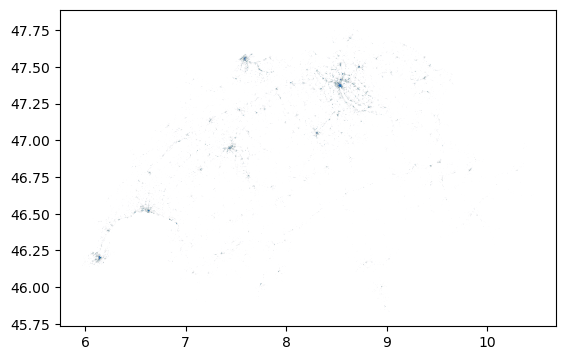

In [13]:
locs.plot()

In [16]:
locs.to_file(os.path.join("..", "data", "geom", "loc_extent.shp"))

# Staypoints

In [3]:
# read file storage
Dataset_file = os.path.join("..", "paths.json")
with open(Dataset_file) as json_file:
    CONFIG = json.load(json_file)

In [4]:
sp = pd.read_csv(os.path.join(CONFIG[f"raw_mobis"], "sps.csv"))
# geometry
sp["geometry"] = gpd.GeoSeries.from_wkt(sp["geometry"])
sp = gpd.GeoDataFrame(sp, crs="EPSG:4326", geometry="geometry")

In [7]:
sp[["geometry"]].to_file(os.path.join("..", "data", "geom", "sp.shp"))